# 03 - Recursive Feature Elimination to Increase Preditive Power

In [1]:
# data processing
import pandas as pd
import numpy as np
import scipy.stats as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import fbeta_score, make_scorer

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')


# model processing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


# other tools
from utils import dataframe_utils, preprocess_utils, feature_importance_utils, model_utils, preprocess_utils
from utils.estimator_wrapper import *
from joblib import dump, load

### Importing pre processed dataset

In [2]:
df_covid = pd.read_csv('datasets/dataset_preprocessed.csv')
df_covid

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Metapneumovirus
0,17,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,0,1,0,0,0,0,0,0,0,0
1,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,0,0,0,0,0,0,0,0,0,0
2,9,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,0,0,0,0,0,0,0,0,1,0
3,11,0,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,0,1,0,0,0,0,0,0,0,0
4,13,0,1.014726,0.854844,-0.178244,0.796029,0.489872,-0.730707,-0.353319,-0.075131,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18,1,1.197836,1.356092,-1.911774,1.132609,0.384090,0.966573,0.841616,-0.834833,...,0,0,0,0,0,0,0,0,0,0
358,19,0,0.190738,0.165628,-0.102873,0.908221,0.384090,-1.583611,-0.054585,-0.328365,...,0,0,0,0,0,0,0,0,0,0
359,19,0,-0.289922,-0.523588,0.663397,-0.774677,0.754327,-1.532437,-1.050367,1.569499,...,0,0,0,0,0,0,0,0,0,0
360,15,0,0.717175,1.105468,-0.492289,-0.213711,0.613284,0.002791,1.538664,-0.550988,...,0,0,0,0,0,0,0,0,0,0


### Train test split and scaling

In [3]:
class_label = 'SARS-Cov-2 exam result'
columns_x = df_covid.drop(axis=1,labels=[class_label]).columns
column_y = [class_label]

X_train, X_test, y_train, y_test = train_test_split(
    df_covid[columns_x], df_covid[column_y],  test_size=0.30, random_state=42)

scaler = MinMaxScaler()
scaler.fit(df_covid[columns_x])
dump(scaler, 'saves/minmax_scaler_no_imputation.bin', compress=True)

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(data=scaler.transform(X_test),columns=X_train.columns)

In [5]:
df_train = X_train_norm
df_train[column_y[0]] = y_train.values

df_train.to_csv('datasets/dataset_preprocessed_train.csv',index = False)

df_test = X_test_norm
df_test[column_y[0]] = y_test.values

df_test.to_csv('datasets/dataset_preprocessed_test.csv',index = False)

## Feature and Model Selection with Recursive Feature Elimination - Cross Validation

Initially, let us compare two models:
- Logistic Regression
- SVM with linear kernel

Also, it will be compared models with and without balanced class weights 

Scoring function will be F2, since it is more costly to have false negatives than false positives

In [4]:
f2_scorer = make_scorer(fbeta_score, beta=2)

### Logistic Regression - with class_weight balanced

Optimal number of features : 6
highest score:  0.7636913284618676


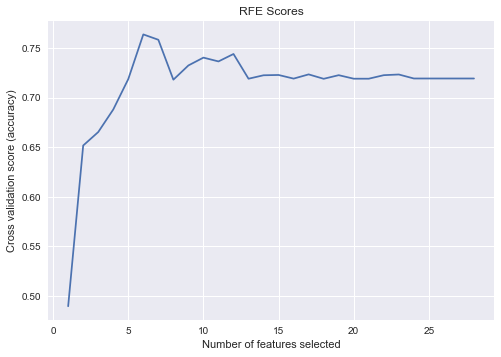


Performance Report: 
Accuracy: 0.826
Recall: 0.829
Precision: 0.723
F1: 0.750
F2: 0.788



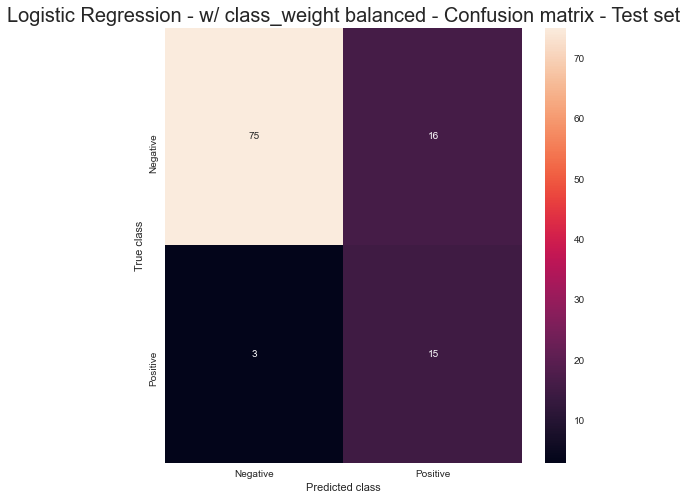

No Skill: ROC AUC=0.500
Logistic Regression - w/ class_weight balanced : ROC AUC=0.880


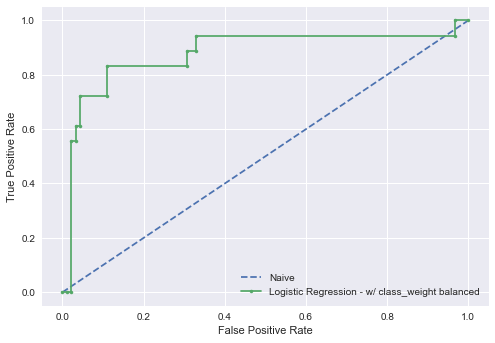

['saves/logistic_regression_no_imputation.bin']

In [5]:
model = LogisticRegression(C = 100, penalty = 'l2',class_weight = 'balanced');
features_lr, _, best_lr, _ = model_utils.model_fit_with_rfe_cv(model,X_train_norm,y_train,folds=5,score = f2_scorer,verbose = 2)
best_lr.fit(X_train_norm[features_lr],y_train.values)

model_utils.evalute_model_performance(best_lr, 'Logistic Regression - w/ class_weight balanced',X_test_norm[features_lr],y_test)
dump(best_lr, 'saves/logistic_regression_no_imputation.bin', compress=True)

### Logistic Regression - without class_weight balanced

Optimal number of features : 25
highest score:  0.6460953346855983


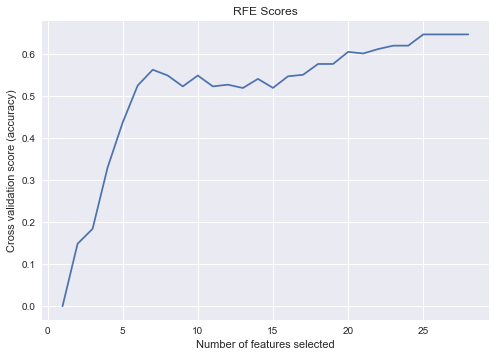


Performance Report: 
Accuracy: 0.908
Recall: 0.789
Precision: 0.856
F1: 0.817
F2: 0.799



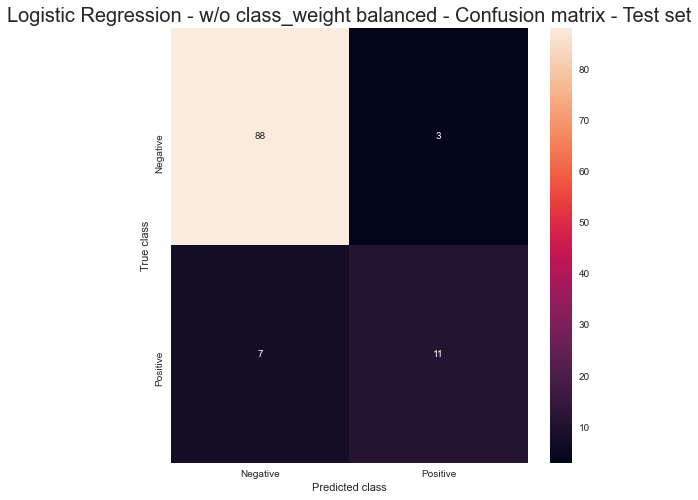

No Skill: ROC AUC=0.500
Logistic Regression - w/o class_weight balanced : ROC AUC=0.900


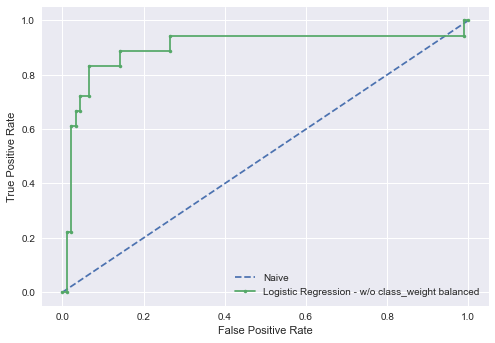

['saves/logistic_regression_no_imputation.bin']

In [6]:
model = LogisticRegression(C = 100, penalty = 'l2',class_weight = None);
features_lr_no_balance, _, best_lr_no_balance, _ = model_utils.model_fit_with_rfe_cv(model,X_train_norm,y_train,folds=5,score = f2_scorer,verbose = 2)
best_lr_no_balance.fit(X_train_norm[features_lr_no_balance],y_train.values)

model_utils.evalute_model_performance(best_lr_no_balance, 'Logistic Regression - w/o class_weight balanced',X_test_norm[features_lr_no_balance],y_test)
dump(best_lr_no_balance, 'saves/logistic_regression_no_imputation.bin', compress=True)

### SVM (linear Kernel) - with class_weight balanced

Optimal number of features : 25
highest score:  0.7576256872462503


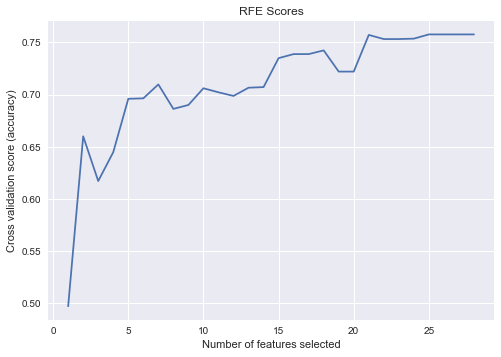


Performance Report: 
Accuracy: 0.872
Recall: 0.856
Precision: 0.770
F1: 0.801
F2: 0.830



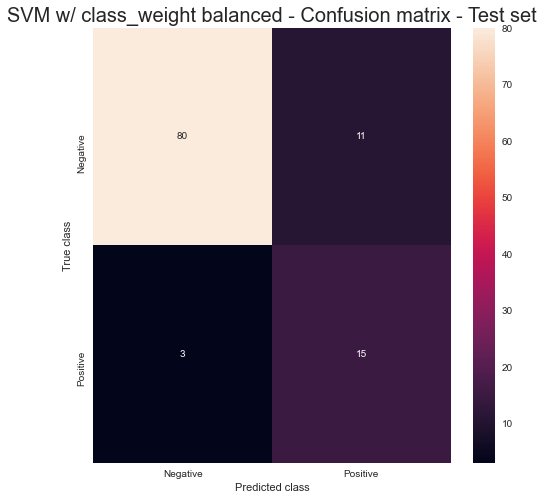

No Skill: ROC AUC=0.500
SVM w/ class_weight balanced : ROC AUC=0.877


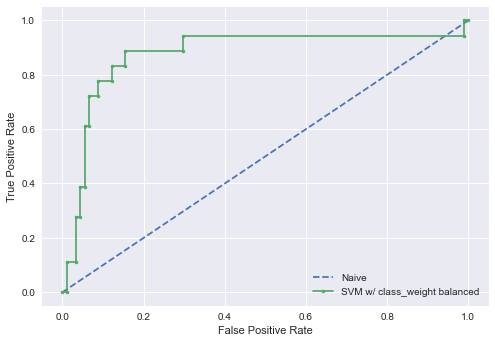

['saves/svm_no_imputation.bin']

In [7]:
model = SVC(C = 100, coef0 = 0, degree = 2, gamma = 'scale',kernel= 'linear',probability = True,class_weight = 'balanced')
features_svm, _, best_svm,_ = model_utils.model_fit_with_rfe_cv(model,X_train_norm,y_train,folds=5,score = f2_scorer,verbose = 2)
best_svm.fit(X_train_norm[features_svm],y_train)

model_utils.evalute_model_performance(best_svm, 'SVM w/ class_weight balanced',X_test_norm[features_svm],y_test)
dump(best_svm, 'saves/svm_no_imputation.bin', compress=True)

### SVM (linear Kernel) - without class_weight balanced

Optimal number of features : 14
highest score:  0.6116883116883116


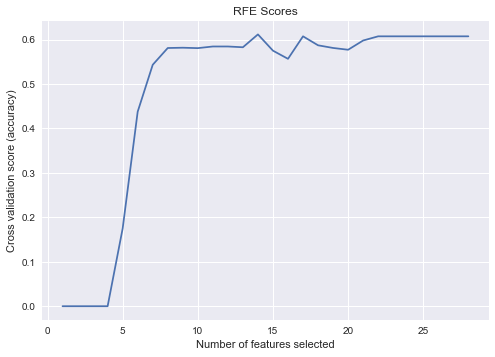


Performance Report: 
Accuracy: 0.890
Recall: 0.778
Precision: 0.806
F1: 0.791
F2: 0.783



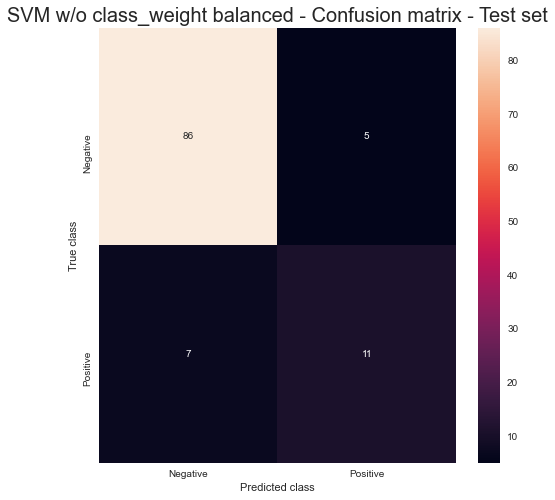

No Skill: ROC AUC=0.500
SVM w/o class_weight balanced : ROC AUC=0.882


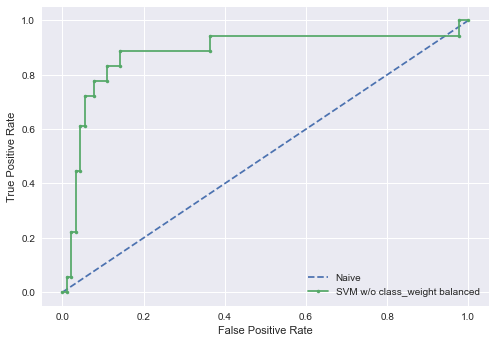

['saves/svm_no_imputation.bin']

In [8]:
model = SVC(C = 100, coef0 = 0, degree = 2, gamma = 'scale',kernel= 'linear',probability = True,class_weight = None)
features_svm_no_balance, _, best_svm_no_balance,_ = model_utils.model_fit_with_rfe_cv(model,X_train_norm,y_train,folds=5,score = f2_scorer,verbose = 2)
best_svm_no_balance.fit(X_train_norm[features_svm_no_balance],y_train)

model_utils.evalute_model_performance(best_svm_no_balance, 'SVM w/o class_weight balanced',X_test_norm[features_svm_no_balance],y_test)
dump(best_svm_no_balance, 'saves/svm_no_imputation.bin', compress=True)

### Random Forest balanced class weight

Optimal number of features : 28
highest score:  0.6927330571727124


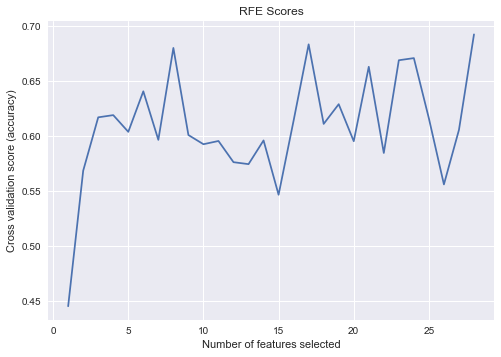


Performance Report: 
Accuracy: 0.936
Recall: 0.850
Precision: 0.907
F1: 0.875
F2: 0.859



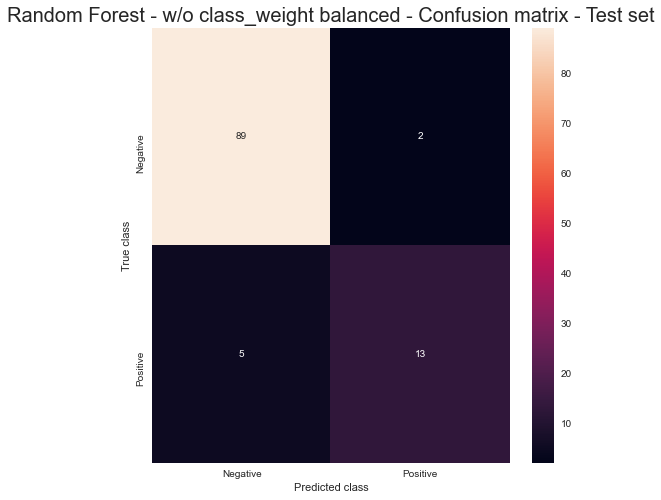

No Skill: ROC AUC=0.500
Random Forest - w/o class_weight balanced : ROC AUC=0.891


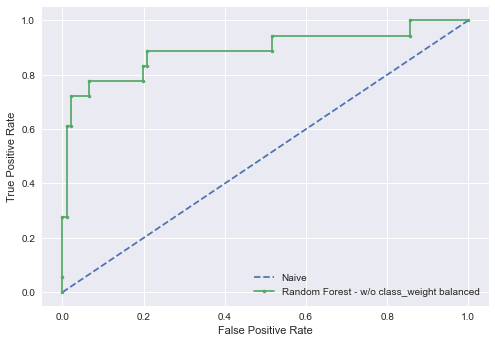

In [20]:
rf_params = {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50, 'oob_score': True}

model = SHAPEstimatorWrapper(RandomForestClassifier,rf_params,estimator_type = 'tree',use_shap = True)

features_rf, _, best_rf, _ = model_utils.model_fit_with_rfe_cv(model,X_train_norm,y_train,folds=5,score = f2_scorer,verbose = 2)
best_rf.fit(X_train_norm[features_rf],y_train.values)

model_utils.evalute_model_performance(best_rf, 'Random Forest - w/o class_weight balanced',X_test_norm[features_rf],y_test)

## Visualizing weights of trained models

### Logistic Regression

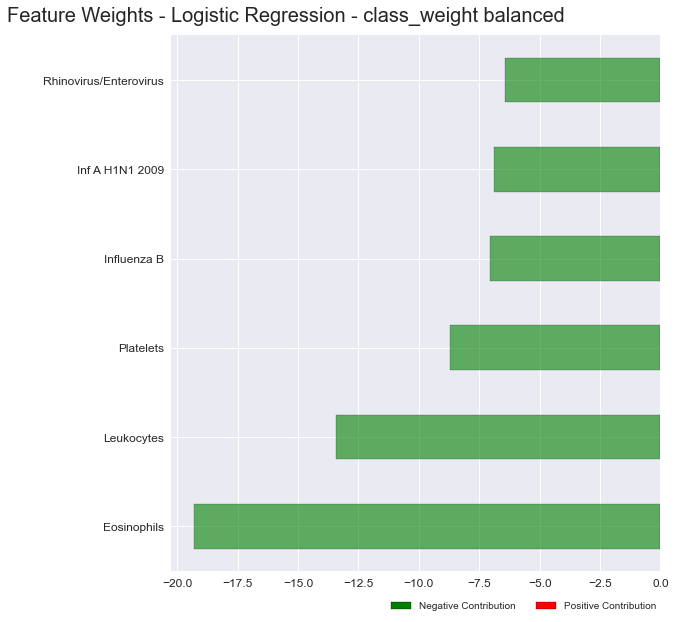

In [9]:
feature_importance_utils.show_feature_weights(features_lr, best_lr.coef_.ravel(),'Logistic Regression - class_weight balanced', color = ('r','g'), absolute_values = False)

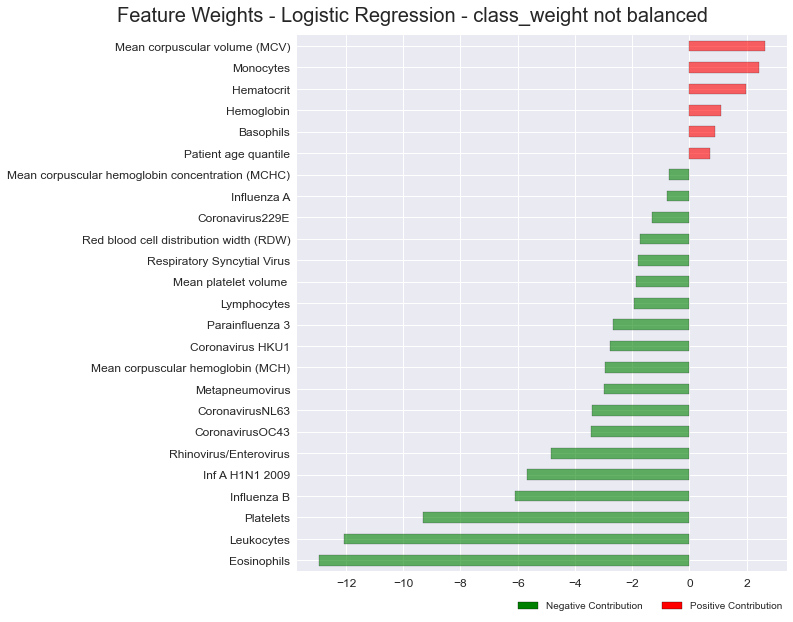

In [10]:
feature_importance_utils.show_feature_weights(features_lr_no_balance,best_lr_no_balance.coef_.ravel(),'Logistic Regression - class_weight not balanced', color = ('r','g'), absolute_values = False)

### SVM

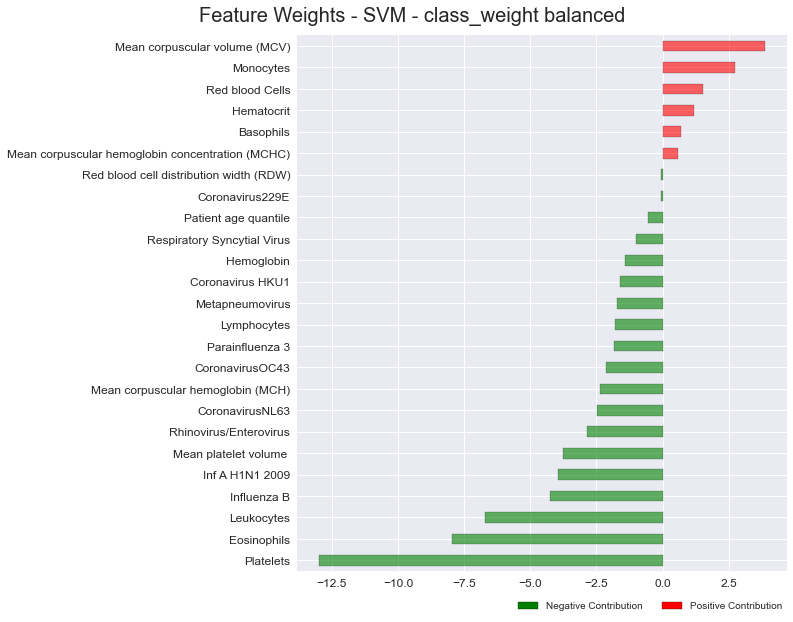

In [11]:
feature_importance_utils.show_feature_weights(features_svm, best_svm.coef_.ravel(),'SVM - class_weight balanced', color = ('r','g'), absolute_values = False)

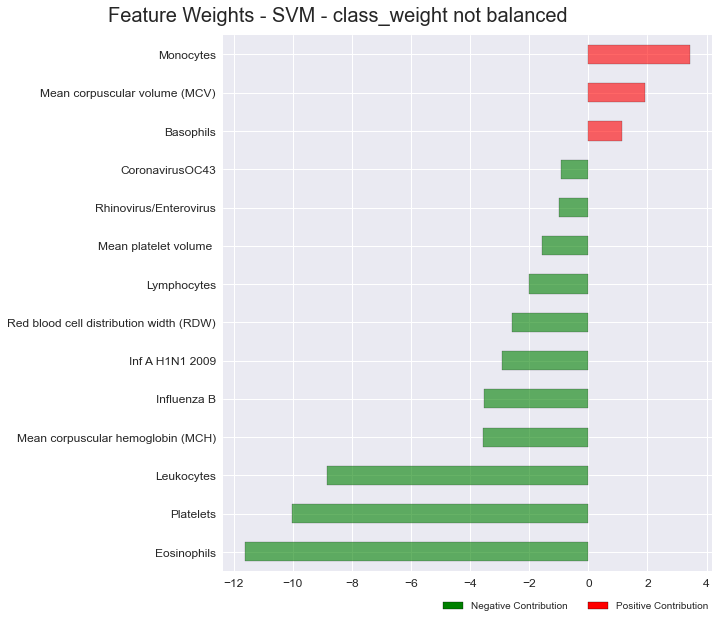

In [12]:
feature_importance_utils.show_feature_weights(features_svm_no_balance,best_svm_no_balance.coef_.ravel(),'SVM - class_weight not balanced', color = ('r','g'), absolute_values = False)

### Random Forest

In [48]:
exp_rf = shap.TreeExplainer(best_rf.estimator,X_train_norm,n_samples = 100)
shap_values_rf = exp_rf.shap_values(X_train_norm,check_additivity=False)[0]
shap_coef_rf = np.abs(shap_values_rf).sum(axis = 0)

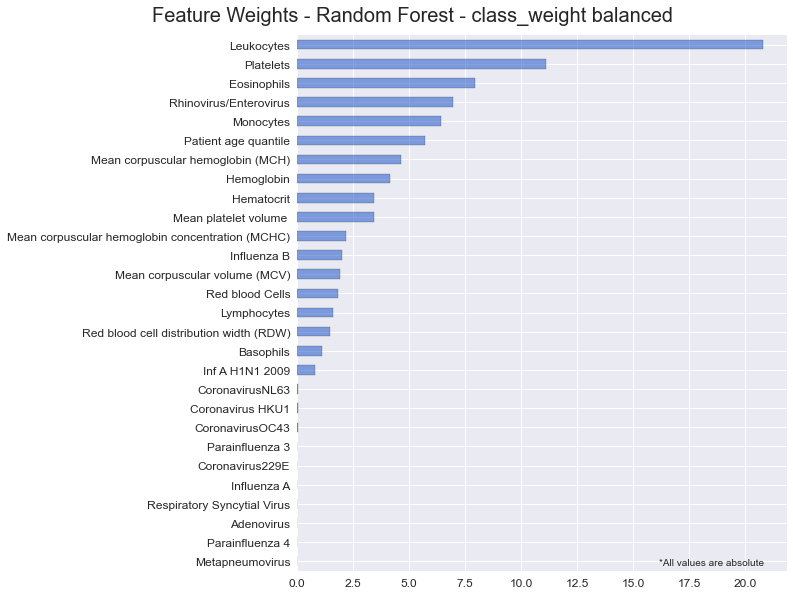

In [47]:
feature_importance_utils.show_feature_weights(features_rf,shap_coef_rf.ravel(),'Random Forest - class_weight balanced', absolute_values = True)